In [1]:
'''Extract mass and metallicity history from Dusty-SAGE output'''

'Extract mass and metallicity history from Dusty-SAGE output'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from random import sample, seed
import copy
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=73, Om0=0.25)
import matplotlib.patheffects as PathEffects

In [4]:
from __future__ import print_function
from os.path import dirname, abspath, join as pjoin
import Corrfunc
from Corrfunc.theory.xi import xi
import re, os

In [5]:
%load_ext line_profiler

In [6]:
def galdtype_dusty(align):
     
    '''Define the data-type for the public version of Dusty-SAGE'''
    
    Galdesc_full = [
        ('SnapNum'                      , np.int32),
        ('Type'                         , np.int32),
        ('GalaxyIndex'                  , np.int64),
        ('CentralGalaxyIndex'           , np.int64),
        ('SAGEHaloIndex'                , np.int32),
        ('SAGETreeIndex'                , np.int32),
        ('SimulationHaloIndex'          , np.int64),
        ('mergeType'                    , np.int32),
        ('mergeIntoID'                  , np.int32),
        ('mergeIntoSnapNum'             , np.int32),
        ('dT'                           , np.float32),
        ('Pos'                          , (np.float32, 3)),
        ('Vel'                          , (np.float32, 3)),
        ('Spin'                         , (np.float32, 3)),
        ('Len'                          , np.int32),
        ('Mvir'                         , np.float32),
        ('CentralMvir'                  , np.float32),
        ('Rvir'                         , np.float32),
        ('Vvir'                         , np.float32),
        ('Vmax'                         , np.float32),
        ('VelDisp'                      , np.float32),
        ('ColdGas'                      , np.float32),
        ('f_H2'                         , np.float32),
        ('f_HI'                         , np.float32),
        ('cf'                           , np.float32),
        ('Zp'                           , np.float32),
        ('Pressure'                     , np.float32),
        ('StellarMass'                  , np.float32),
        ('BulgeMass'                    , np.float32),
        ('BulgeInstability'             , np.float32),
        ('HotGas'                       , np.float32),
        ('EjectedMass'                  , np.float32),
        ('BlackHoleMass'                , np.float32),
        ('IntraClusterStars'            , np.float32),
        ('MetalsColdGas'                , np.float32),
        ('MetalsStellarMass'            , np.float32),
        ('MetalsBulgeMass'              , np.float32),
        ('MetalsHotGas'                 , np.float32),
        ('MetalsEjectedMass'            , np.float32),
        ('MetalsIntraClusterStars'      , np.float32),
        ('ColdDust'                     , np.float32),
        ('HotDust'                      , np.float32),
        ('EjectedDust'                     , np.float32),
        ('SfrDisk'                      , np.float32),
        ('SfrBulge'                     , np.float32),
        ('SfrDiskZ'                     , np.float32),
        ('SfrBulgeZ'                    , np.float32),
        ('SfrDiskDTG'                     , np.float32),
        ('SfrBulgeDTG'                    , np.float32),
        ('dustdotform'                  , np.float32),
        ('dustdotgrowth'                    , np.float32),
        ('dustdotdestruct'                    , np.float32),
#        ('Sfr'                          , (np.float32, 64)),
        ('DiskRadius'                   , np.float32),
        ('Cooling'                      , np.float32),
        ('Heating'                      , np.float32),
        ('QuasarModeBHaccretionMass'    , np.float32),
        ('TimeOfLastMajorMerger'         , np.float32),
        ('TimeOfLastMinorMerger'         , np.float32),
        ('OutflowRate'                  , np.float32),
        ('infallMvir'                   , np.float32),
        ('infallVvir'                   , np.float32),
        ('infallVmax'                   , np.float32)
        ]
    names = [Galdesc_full[i][0] for i in range(len(Galdesc_full))]
    formats = [Galdesc_full[i][1] for i in range(len(Galdesc_full))]
    if(align==True):
        Galdesc = np.dtype({'names':names, 'formats':formats}, align=True)
    else:
        Galdesc = np.dtype({'names':names, 'formats':formats})
    return Galdesc

In [7]:
def galdtype(align):
    
    '''Define the data-type for the public version of SAGE'''
    
    Galdesc_full = [
        ('SnapNum'                      , np.int32),
        ('Type'                         , np.int32),
        ('GalaxyIndex'                  , np.int64),
        ('CentralGalaxyIndex'           , np.int64),
        ('SAGEHaloIndex'                , np.int32),
        ('SAGETreeIndex'                , np.int32),
        ('SimulationHaloIndex'          , np.int64),
        ('mergeType'                    , np.int32),
        ('mergeIntoID'                  , np.int32),
        ('mergeIntoSnapNum'             , np.int32),
        ('dT'                           , np.float32),
        ('Pos'                          , (np.float32, 3)),
        ('Vel'                          , (np.float32, 3)),
        ('Spin'                         , (np.float32, 3)),
        ('Len'                          , np.int32),
        ('Mvir'                         , np.float32),
        ('CentralMvir'                  , np.float32),
        ('Rvir'                         , np.float32),
        ('Vvir'                         , np.float32),
        ('Vmax'                         , np.float32),
        ('VelDisp'                      , np.float32),
        ('ColdGas'                      , np.float32),
        ('StellarMass'                  , np.float32),
        ('BulgeMass'                    , np.float32),
        ('HotGas'                       , np.float32),
        ('EjectedMass'                  , np.float32),
        ('BlackHoleMass'                , np.float32),
        ('IntraClusterStars'            , np.float32),
        ('MetalsColdGas'                , np.float32),
        ('MetalsStellarMass'            , np.float32),
        ('MetalsBulgeMass'              , np.float32),
        ('MetalsHotGas'                 , np.float32),
        ('MetalsEjectedMass'            , np.float32),
        ('MetalsIntraClusterStars'      , np.float32),
        ('SfrDisk'                      , np.float32),
        ('SfrBulge'                     , np.float32),
        ('SfrDiskZ'                     , np.float32),
        ('SfrBulgeZ'                    , np.float32),
        ('DiskRadius'                   , np.float32),
        ('Cooling'                      , np.float32),
        ('Heating'                      , np.float32),
        ('QuasarModeBHaccretionMass'    , np.float32),
        ('TimeOfLastMajorMerger'         , np.float32),
        ('TimeOfLastMinorMerger'         , np.float32),
        ('OutflowRate'                  , np.float32),
        ('infallMvir'                   , np.float32),
        ('infallVvir'                   , np.float32),
        ('infallVmax'                   , np.float32)
        ]
    names = [Galdesc_full[i][0] for i in range(len(Galdesc_full))]
    formats = [Galdesc_full[i][1] for i in range(len(Galdesc_full))]
    if(align==True):
        Galdesc = np.dtype({'names':names, 'formats':formats}, align=True)
    else:
        Galdesc = np.dtype({'names':names, 'formats':formats})
    return Galdesc

In [31]:
def iterate_trees(SAM_option, directory, firstfile, lastfile):
    '''
    Iterating trees from the simulation output.
    Currently, it can only read trees from SAGE (Croton et al. 2006, 2016)
    and dusty-sage (Triani et al. 2020)
    
    Input:  - SAM option (int): (0) SAGE (1) Dusty-SAGE
            - path of the directory containing simulation output (string).
              Format of the simulation output: model_zX.XXX_Y
              X.XXX : redshift of the snapshot
              Y : file number
    
    Output: a tree, consist of properties of galaxies listed in galdtype_dusty()
    '''
    
    #define variables
    entries = [e for e in os.listdir(directory) 
               if os.path.isfile(os.path.join(directory, e))]
    entries = [e for e in entries if e.startswith('model_z')]
    redshift_strings = list(set([re.match(r'model_z(\d+\.?\d*)_\d+', e).group(1)
                                for e in entries]))
#    group_strings = list(set([re.match(r'model_z\d+\.?\d*_(\d+)', e).group(1)
#                            for e in entries]))
    
#    group_strings.sort(key=lambda x: int(x))
    redshift_strings.sort(key=lambda x: float(x), reverse=True)
    
    if SAM_option == 0:
        Galdesc_false = galdtype(align=False)
        Galdesc=galdtype(align=True)
    elif SAM_option == 1:
        Galdesc_false = galdtype_dusty(align=False)
        Galdesc=galdtype_dusty(align=True)
    else:
        print("Choose a SAM: 0 - for SAGE, 1 - for Dusty-SAGE")
    
    #open files
    for group in range(firstfile, lastfile+1):
#    for group in group_strings:
        files = []
        for redshift in redshift_strings:
            fn = 'model_z%s_%s' % (redshift, group)
            files.append(open(os.path.join(directory, fn), 'rb'))

        n_trees = [np.fromfile(f, np.uint32, 1)[0] for f in files][0]
        n_gals = [np.fromfile(f, np.uint32, 1)[0] for f in files]
        chunk_sizes = [np.fromfile(f, np.uint32, n_trees) for f in files]
        tree_sizes = sum(chunk_sizes, axis=0)
        
        for ii in range(n_trees):
            tree_size = tree_sizes[ii]
            tree = np.empty(tree_size, dtype=Galdesc_false)
            offs=0
            for jj in range(len(chunk_sizes)):
                chunk_size = chunk_sizes[jj][ii]
                if chunk_size <= 0: continue

                data = np.fromfile(files[jj], Galdesc, chunk_size)

                for _v in data.dtype.names:
                    tree[_v][offs:offs+chunk_size] = data[_v]
                offs += chunk_size

            # First validate ID's.
            for f in ['Type', 'GalaxyIndex', 'CentralGalaxyIndex']:
                if min(tree[f]) < 0:
                    print("ERROR; min(tree[{0}]) = {1} should be non-zero"
                            .format(f, min(tree[f])))
                    raise ValueError()

            # Validate central galaxy index (unique id, generated by sage)
            ind = (np.where(tree['Type'] == 0))[0]
            if not bool(np.all(tree['GalaxyIndex'][ind] == tree['CentralGalaxyIndex'][ind])):
                print("tree[GalaxyIndex][ind] = {0}".format(tree['GalaxyIndex'][ind]))
                print("tree[CentralGalaxyIndex][ind] = {0}".format(tree['CentralGalaxyIndex'][ind]))

            assert bool(np.all(tree['GalaxyIndex'][ind] ==
                            tree['CentralGalaxyIndex'][ind])), \
                "Central Galaxy Index must equal Galaxy Index for centrals"

            yield tree
            
        for file in files:
            file.close()

In [15]:
def calculate_mass_and_metals(SAM_choice, tree, snap_limit):
    
    """Calculate mass history from Dusty-SAGE tree.
    In one fly, it will calculate the mass and metals history of a tree while mapping
    the descendant.
    
    Input:  - SAM_choice (int): (0) SAGE (1) Dusty-SAGE
            - a tree yielded by iterate_tree(directory)
            - snap_limit (int) -- last snapshot of the tree
    Output: 2-dimensions array.
            1st array: Stellar mass history of the tree (in h*Msun)
            2nd array: Stellar metallicity history (no unit)
            Both arrays consists of a number of snapshot, ascending with increasing age of Universe.
    """
    
    recycle_fraction = 0.43
    sorted_idx = np.argsort(tree, order=('GalaxyIndex', 'SnapNum'))
    all_gal_ID = tree['GalaxyIndex']
    snapshot_nr = tree['SnapNum']
    merge_idx = tree['mergeIntoID']
    merge_snapshot = tree['mergeIntoSnapNum']
    merge_type = tree['mergeType']

    delta_bulge = tree['SfrBulge'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
    delta_disk = tree['SfrDisk'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
    delta_mass = delta_bulge + delta_disk

    
    if SAM_choice == 0:
        delta_bulge_metals = tree['SfrBulgeZ']  * tree['SfrBulge'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_disk_metals = tree['SfrDiskZ'] * tree['SfrDisk'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_metals = delta_bulge_metals + delta_disk_metals 

    elif SAM_choice == 1:
        delta_bulge_metals = tree['SfrBulgeZ']  * tree['SfrBulge'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_disk_metals = tree['SfrDiskZ'] * tree['SfrDisk'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_bulge_dust = tree['SfrBulgeDTG'] * tree['SfrBulge'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_disk_dust = tree['SfrDiskDTG'] * tree['SfrDisk'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_metals = delta_bulge_metals + delta_disk_metals + delta_bulge_dust + delta_disk_dust
    else:
        print("Choose a SAM: 0 - for SAGE, 1 - for Dusty-SAGE")
    
    unique_ID = np.unique(all_gal_ID)
    mass = np.zeros((len(unique_ID), max(snapshot_nr)+1))
    metals = np.zeros((len(unique_ID), max(snapshot_nr)+1))
    
    #map descendant and build mass and metal history
    for kk, gal_ID in enumerate(unique_ID):
        instant_mass = 0.0
        instant_metals = 0.0
        for ii, ID in enumerate(all_gal_ID[sorted_idx]):
            if(gal_ID == ID):
                instant_mass += delta_mass[sorted_idx[ii]] 
                mass[kk][snapshot_nr[sorted_idx[ii]]] = instant_mass
                assert mass[kk][snapshot_nr[sorted_idx[ii]]] >= mass[kk][snapshot_nr[sorted_idx[ii-1]]]
                
                instant_metals += delta_metals[sorted_idx[ii]]
                metals[kk][snapshot_nr[sorted_idx[ii]]] = instant_metals
                assert metals[kk][snapshot_nr[sorted_idx[ii]]] >= metals[kk][snapshot_nr[sorted_idx[ii-1]]]
    
    
    #make sure the mass and metals are increasing with snapshot_nr   
    for i in range(len(unique_ID)):
        for j in range(max(snapshot_nr)):
            if (mass[i][j+1] < mass[i][j]):
                mass[i][j+1] = mass[i][j]
                
            if (metals[i][j+1] < metals[i][j]):
                metals[i][j+1] = metals[i][j]
            
    #identify merger and add mass
    for snap in range(max(snapshot_nr)+1):
        wsnap = np.where(snapshot_nr == snap)[0]
        wmerge = np.where((merge_idx[wsnap] != -1) & (merge_snapshot[wsnap] < snap_limit) & (merge_type[wsnap] < 3))[0] #only include major (merge_type=1) and minor (merge_type=2) merger
        merger_snap = merge_snapshot[wsnap][wmerge]
        merger_id = merge_idx[wsnap][wmerge]
        
        if len(merger_id) > 0:
            for i, idx in enumerate(merger_id):
                
                wmergesnap = np.where(snapshot_nr == merger_snap[i])[0]
                central_ID = all_gal_ID[wmergesnap][idx]
                central_idx = np.where(unique_ID[:,None] == central_ID)[0]
                satellite_ID = all_gal_ID[wsnap][wmerge][i]
                satellite_idx = np.where(unique_ID[:,None] == satellite_ID)[0]
                
                #added satellite mass to central mass
                mass[central_idx] = mass[central_idx] + mass[satellite_idx]
            
                #eliminate the mass of satellite galaxies
                mass[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                
                #added satellite metals to central
                metals[central_idx] = metals[central_idx] + metals[satellite_idx]
                
                #eliminate the metals of satellite galaxies
                metals[satellite_idx] = np.zeros(max(snapshot_nr)+1)
               
        #null more satellite (from mergetype 3 and 4)
        wmerge = np.where((merge_idx[wsnap] != -1) & (merge_snapshot[wsnap] < snap_limit) & (merge_type[wsnap] > 2))[0]
        merger_snap = merge_snapshot[wsnap][wmerge]
        merger_id = merge_idx[wsnap][wmerge]
        

        if len(merger_id) > 0:
            for i, idx in enumerate(merger_id):
                wmergesnap = np.where(snapshot_nr == merger_snap[i])[0]
                satellite_ID = all_gal_ID[wsnap][wmerge][i]
                satellite_idx = np.where(unique_ID[:,None] == satellite_ID)[0]
                
                #eliminate the mass of satellite galaxies but don't add it to the central
                mass[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                
                #the metals as well
                metals[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                
        #Finally, divide total metals to total mass:
        w = np.where((metals[:,snap] !=0) & (mass[:,snap] != 0))[0]
        metals[w,snap] = metals[w,snap] / mass[w,snap]
                
    return mass, metals

In [30]:
def build_mass_and_metallicity_history(SAM_choice, directory, firstfile, lastfile, snap_limit):
    '''
    Build mass and metallicity history from the output directory of dusty-sage
    Input:  - SAM_choice (int): (0) SAGE (1) Dusty-SAGE
            - directory (string) -- path to the directory containing dusty-sage output tree
            - snap_limit (integer) -- number of last snapshot
            
    Output: - Mass (array(list(float))) -- an array containing a number of galaxy, each containing mass (in Msun/h) of each snapshot
            - Metallicity (array(list(float))) -- an array containing a number of galaxy, each containing stellar metallicity of each snapshot

    '''
    Mass = []
    Metals = []

    for tree in iterate_trees(SAM_choice, directory, firstfile, lastfile):
        mass, metal = calculate_mass_and_metals(SAM_choice, tree, snap_limit)
        Mass.extend(mass)
        Metals.extend(metal)

    Mass = np.array(Mass)
    Metals = np.array(Metals)
    
    return(Mass, Metals)

In [17]:
def open_file(filename):
    
    '''
    Open file, read each line, split each line into each float number.
    Create an list consists of all the number (float) in the file.
    
    Input: - filename (str) -- name of file to be opened
    Output: - M (list(float)) -- a list of float consists of all number in the file named filename
    '''
    
    f = open(filename, "r")
    M = []
    for elem in f.read().split():
        try:
            M.append(float(elem))
        except ValueError:
            pass
    f.close()
    
    return M

In [18]:
def generate_SED(SSP, Age, MassHist, MetalHist):
    
    '''
    Generate intrinsice (stellar) SED by assembling SSP from BC03.
    
    Input:  - Choice_of_SSP (int) : 0 - BC03
            - Age : 1-dimension array consists of age of universe in Gyr
            - MassHist: N-dimension array, with N=number of galaxy.
                        Each array consists of stellar mass (in Msun) of each galaxy at corresponding age of Universe.
            - MetalHist: N-dimension array, with N=number of galaxy.
                         Each array consists of stellar metallicity (metals/stellar mass) of each galaxy at corresponding age of Universe.
                         
    Output: - Wavelength: 1-dimension array with 6900 wavelength in micrometer.
            - Luminosity: N-dimension array, with N=number of galaxy.
                          Each array consists of luminosity of galaxy at corresponding wavelength.
    
    '''
    
    #SSP = 0 (Bruzual & Charlot 2003 -- BC03)
    if (SSP == 0): 
        
        FileNames = ["files/bc2003_hr_m22_chab_ssp.ised_ASCII", "files/bc2003_hr_m32_chab_ssp.ised_ASCII",
                "files/bc2003_hr_m42_chab_ssp.ised_ASCII", "files/bc2003_hr_m52_chab_ssp.ised_ASCII", 
                "files/bc2003_hr_m62_chab_ssp.ised_ASCII", "files/bc2003_hr_m72_chab_ssp.ised_ASCII"]
        
        AllFiles = []
        for i in range(len(FileNames)):
            AllFiles.append(open_file(FileNames[i]))
        
        File1 = AllFiles[0]
        lookback = File1[1:222]
        wavelength = File1[236: 7136]
        metallicity = [0.0001, 0.0004, 0.004, 0.008, 0.02, 0.05] #metallicity grid in BC03
        time_grid = 221
        wave_grid = 6900
        lum = np.zeros((len(AllFiles), time_grid, wave_grid))

        for j in range(len(metallicity)):
            File = AllFiles[j]
            for i in range(time_grid):
                lum[j][i] = File[7137 + (wave_grid+54)*i: 7137 + (wave_grid+54)*i + 6900]
    else:
        print("No valid SSP selected.")
        return()
      
    #Check if all mass and metal history have the same number of timestep
    if(len(MassHist) > 1):
        for i in range(len(MassHist)):
            if len(MassHist[i]) != len(MassHist[0]):
                print("Not all galaxies have mass history at snapshot=",i)
                return()
            if len(MetalHist[i]) != len(MetalHist[0]):
                print("Not all galaxies have metal history at snapshot=", i)
                return()
    
    if(len(MassHist) > 1):
        gal_number = len(MassHist)
    else:
        gal_number = 1
        
    new_mass_hist = np.zeros((time_grid, gal_number))
    new_metal_hist = np.zeros((time_grid, gal_number))

#   Build new mass and metal history based on the lookback time of BC03
    for i in range(gal_number):
        lookbacktime = age_to_lookback(Age)
        sorted_lbtime = sorted(lookbacktime)
        
        temp_mass_list = list(MassHist[i])
        temp_metal_list = list(MetalHist[i])
        temp_mass_list.reverse()
        temp_metal_list.reverse()
        
        new_mass_hist[:,i] = np.interp(lookback, sorted_lbtime, temp_mass_list) 
        new_metal_hist[:,i] = np.interp(lookback, sorted_lbtime, temp_metal_list) 

    #Count half metallicity of metallicity grids from BC03
    half_metal = [0] * (len(metallicity) - 1)
    for i in range(len(half_metal)):
        half_metal[i] = (metallicity[i] + metallicity[i+1]) / 2
    
    print('Building SED')
    total_lum = np.zeros((gal_number, wave_grid))
    for i in range(len(lookback) - 1):
        if i%22 == 0:
            print(int(i*100/219),'%',end = '')
        else: 
            print('.',end = '')
        #print("Timestep", i, "/", len(lookback) - 2)
        delta_mass = new_mass_hist[i] - new_mass_hist[i+1]
        deltamass = np.reshape(delta_mass, (-1, 1))
        
        w1 = np.where(new_metal_hist[i] < half_metal[0])[0]
        total_lum[w1] += deltamass[w1] * lum[0][i]
        
        for j in range(len(half_metal)-1):
            w2 = np.where((new_metal_hist[i] > half_metal[j]) & (new_metal_hist[i] <= half_metal[j+1]))[0]
            total_lum[w2] += deltamass[w2] * lum[j+1][i]
            
        w3 = np.where(new_metal_hist[i] > half_metal[-1])[0]
        total_lum[w3] += deltamass[w3] * lum[-1][i]
        
    return wavelength, total_lum

In [19]:
def age_to_lookback(age): #age in Gyr, lookback in yr
    
    '''
    Convert age of Universe to lookback time
    Input: age (list(float)) -- age of universe, in Gyr
    Output: lookback time (list(float)) -- corresponding lookback time, in yr
    '''
    lookback = (np.array([13.6098]*len(age)) - age) * 1.e9
    return lookback

In [20]:
def read_filters():
    
    '''
    Reading filters wavelength and response listed in 'files/allfilters.dat'
    '''
    
    F = type('', (), {})
    F.wavelength, F.response = np.loadtxt('files/allfilters.dat', unpack=True)
    F.Johnson_V_wave = F.wavelength[0:24]
    F.Johnson_V = F.response[0:24]
    F.Johnson_U_wave = F.wavelength[24:49]
    F.Johnson_U = F.response[24:49]
    F.Johnson_B_wave = F.wavelength[49:70]
    F.Johnson_B = F.response[49:70]
    F.Buser_B2_wave = F.wavelength[70:110]
    F.Buser_B2 = F.response[70:110]
    F.Cousins_R_wave = F.wavelength[110:175]
    F.Cousins_R = F.response[110:175]
    F.Cousins_I_wave = F.wavelength[175:214]
    F.Cousins_I = F.response[175:214]
    F.Deep_B_wave = F.wavelength[214:584]
    F.Deep_B = F.response[214:584]
    F.Deep_R_wave = F.wavelength[584:750]
    F.Deep_R = F.response[584:750]
    F.Deep_I_wave = F.wavelength[750:1106]
    F.Deep_I = F.response[750:1106]
    F.TwoMass_J_wave = F.wavelength[1106:1214]
    F.TwoMass_J = F.response[1106:1214]
    F.TwoMass_H_wave = F.wavelength[1214:1272]
    F.TwoMass_H = F.response[1214:1272]
    F.TwoMass_Ks_wave = F.wavelength[1272:1347]
    F.TwoMass_Ks = F.response[1272:1347]
    F.Sdss_u_wave = F.wavelength[1347:1394]
    F.Sdss_u = F.response[1347:1394]
    F.Sdss_g_wave = F.wavelength[1394:1483]
    F.Sdss_g = F.response[1394:1483]
    F.Sdss_r_wave = F.wavelength[1483:1558]
    F.Sdss_r = F.response[1483:1558]
    F.Sdss_i_wave = F.wavelength[1558:1647]
    F.Sdss_i = F.response[1558:1647]
    F.Sdss_z_wave = F.wavelength[1647:1788]
    F.Sdss_z = F.response[1647:1788]
    F.WFPC2_F255W_wave = F.wavelength[1788:11788]
    F.WFPC2_F255W = F.response[1788:11788]
    F.WPC2_F300W_wave = F.wavelength[11788:21788]
    F.WFPC2_F300W = F.response[11788:21788]
    F.WFPC2_F336W_wave = F.wavelength[21788:31788]
    F.WFPC2_F336W = F.response[21788:31788]
    F.WFPC2_F439W_wave = F.wavelength[31788:41788]
    F.WFPC2_F439W = F.response[31788:41788]
    F.WFPC2_F450W_wave = F.wavelength[41788:51788]
    F.WFPC2_F450W = F.response[41788:51788]
    F.WFPC2_F555W_wave = F.wavelength[51788:61788]
    F.WFPC2_F555W = F.response[51788:61788]	
    F.WFPC2_F606W_wave = F.wavelength[61788:71788]
    F.WFPC2_F606W = F.response[61788:71788]
    F.WFPC2_F814W_wave = F.wavelength[71788:81788]
    F.WFPC2_F814W = F.response[71788:81788]
    F.WFPC2_F850W_wave = F.wavelength[81788:91788]
    F.WFPC2_F850W = F.response[81788:91788]
    F.WFCACS_F435W_wave = F.wavelength[91788:101788]
    F.WFCACS_F435W = F.response[91788:101788]
    F.WFCACS_F475W_wave = F.wavelength[101788:111788]
    F.WFCACS_F475W = F.response[101788:111788]
    F.WFCACS_F555W_wave = F.wavelength[111788:121788]
    F.WFCACS_F555W = F.response[111788:121788]
    F.WFCACS_F606W_wave = F.wavelength[121788:131788]
    F.WFCACS_F606W = F.response[121788:131788]
    F.WFCACS_F625W_wave = F.wavelength[131788:141788]
    F.WFCACS_F625W = F.response[131788:141788]
    F.WFCACS_F775W_wave = F.wavelength[141788:151788]
    F.WFCACS_F775W = F.response[141788:151788]
    F.WFCACS_F814W_wave = F.wavelength[151788:161788]
    F.WFCACS_F814W = F.response[151788:161788]
    F.WFCACS_F850W_wave = F.wavelength[161788:171788]
    F.WFCACS_F850W = F.response[161788:171788]
    F.WFC3UVIS_F218W_wave = F.wavelength[171788:180742]
    F.WFC3UVIS_F218W = F.response[171788:180742]
    F.WFC3UVIS_F225W_wave = F.wavelength[180742:189757]
    F.WFC3UVIS_F225W = F.response[180742:189757]
    F.WFC3UVIS_F275W_wave = F.wavelength[189757:198762]
    F.WFC3UVIS_F275W = F.response[189757:198762]
    F.WFC3UVIS_F336W_wave = F.wavelength[198762:207777]
    F.WFC3UVIS_F336W = F.response[198762:207777]
    F.WFC3UVIS_F390W_wave = F.wavelength[207777:216792]
    F.WFC3UVIS_F390W = F.response[207777:216792]	
    F.WFC3UVIS_F438W_wave = F.wavelength[216792:225807]
    F.WFC3UVIS_F438W = F.response[216792:225807]
    F.WFC3UVIS_F475W_wave = F.wavelength[225807:234822]
    F.WFC3UVIS_F475W = F.response[225807:234822]
    F.WFC3UVIS_F555W_wave = F.wavelength[234822:243837]
    F.WFC3UVIS_F555W = F.response[234822:243837]	
    F.WFC3UVIS_F606W_wave = F.wavelength[243837:252792]
    F.WFC3UVIS_F606W = F.response[243837:252792]
    F.WFC3UVIS_F775W_wave = F.wavelength[252792:261807]
    F.WFC3UVIS_F775W = F.response[252792:261807]
    F.WFC3UVIS_F814W_wave = F.wavelength[261807:270822]
    F.WFC3UVIS_F814W = F.response[261807:270822]	
    F.WFC3UVIS_F850W_wave = F.wavelength[270822:279837]
    F.WFC3UVIS_F850W = F.response[270822:279837]
    F.WFC3IR_F098M_wave = F.wavelength[279837:284338]
    F.WFC3IR_F098M = F.response[279837:284338]
    F.WFC3IR_F105W_wave = F.wavelength[284338:293339]
    F.WFC3IR_F105W = F.response[284338:293339]
    F.WFC3IR_F110W_wave = F.wavelength[284338:302340]
    F.WFC3IR_F110W = F.response[284338:302340]
    F.WFC3IR_F125W_wave = F.wavelength[302340:311340]
    F.WFC3IR_F125W = F.response[302340:311340]
    F.WFC3IR_F140W_wave = F.wavelength[311340:320341]
    F.WFC3IR_F140W = F.response[311340:320341]
    F.WFC3IR_F160W_wave = F.wavelength[320341:329342]
    F.WFC3IR_F160W = F.response[320341:329342]
    F.IRAC_1_wave = F.wavelength[329342:329847]
    F.IRAC_1 = F.response[329342:329847]
    F.IRAC_2_wave = F.wavelength[329847:330274]
    F.IRAC_2 = F.response[329847:330274]
    F.IRAC_3_wave = F.wavelength[330274:330644]
    F.IRAC_3 = F.response[330274:330644]
    F.IRAC_4_wave = F.wavelength[330644:331065]
    F.IRAC_4 = F.response[330644:331065]
    F.ISAAC_Ks_wave = F.wavelength[331065:331265]
    F.ISAAC_Ks = F.response[331065:331265]
    F.FORS_V_wave = F.wavelength[331265:331765]
    F.FORS_V = F.response[331265:331765]
    F.FORS_R_wave = F.wavelength[331765:332265]
    F.FORS_R = F.response[331765:332265]	
    F.NIC_F110W_wave = F.wavelength[332265:334264]
    F.NIC_F110W = F.response[332265:334264]	
    F.NIC_F160W_wave = F.wavelength[334264:335868]
    F.NIC_F160W = F.response[334264:335868]	
    F.GALEX_FUV_wave = F.wavelength[335868:336369]
    F.GALEX_FUV = F.response[335868:336369]	
    F.GALEX_NUV_wave = F.wavelength[335868:337710]
    F.GALEX_NUV = F.response[335868:337710]
    F.DES_g_wave = F.wavelength[337710:337900]
    F.DES_g = F.response[337710:337900]	
    F.DES_r_wave = F.wavelength[337900:338100]
    F.DES_r = F.response[337900:338100]	
    F.DES_i_wave = F.wavelength[338100:338290]
    F.DES_i = F.response[338100:338290]
    F.DES_z_wave = F.wavelength[338290:338480]
    F.DES_z = F.response[338290:338480]
    F.DES_Y_wave = F.wavelength[338480:338570]
    F.DES_Y = F.response[338480:338570]
    F.WFCAM_Z_wave = F.wavelength[338570:338723]
    F.WFCAM_Z = F.response[338570:338723]
    F.WFCAM_Y_wave = F.wavelength[338723:338890]
    F.WFCAM_Y = F.response[338723:338890]
    F.WFCAM_J_wave = F.wavelength[338890:339139]
    F.WFCAM_J = F.response[338890:339139]
    F.WFCAM_H_wave = F.wavelength[339139:339642]
    F.WFCAM_H = F.response[339139:339642]
    F.WFCAM_K_wave = F.wavelength[339642:340216]
    F.WFCAM_K = F.response[339642:340216]
    F.Steidel_Un_wave = F.wavelength[340216:340259]
    F.Steidel_Un = F.response[340216:340259]
    F.Steidel_G_wave = F.wavelength[340259:340430]
    F.Steidel_G = F.response[340259:340430]
    F.Steidel_Rs_wave = F.wavelength[340430:341239]
    F.Steidel_Rs = F.response[340430:341239]
    F.Steidel_I_wave = F.wavelength[341239:341636]
    F.Steidel_I = F.response[341239:341636]
    F.MegaCam_u_wave = F.wavelength[341636:341768]
    F.MegaCam_u = F.response[341636:341768]
    F.MegaCam_g_wave = F.wavelength[341768:342009]
    F.MegaCam_g = F.response[341768:342009]
    F.MegaCam_r_wave = F.wavelength[342009:342239]
    F.MegaCam_r = F.response[342009:342239]
    F.MegaCam_i_wave = F.wavelength[342239:342378]
    F.MegaCam_i = F.response[342239:342378]
    F.MegaCam_z_wave = F.wavelength[342378:342530]
    F.MegaCam_z = F.response[342378:342530]
    F.WISE_W1_wave = F.wavelength[342530:342717]
    F.WISE_W1 = F.response[342530:342717]
    F.WISE_W2_wave = F.wavelength[342717:342967]
    F.WISE_W2 = F.response[342717:342967]
    F.WISE_W3_wave = F.wavelength[342967:344467]
    F.WISE_W3 = F.response[342967:344467]
    F.WISE_W4_wave = F.wavelength[344467:345679]
    F.WISE_W4 = F.response[344467:345679]
    F.UVOT_w2_wave = F.wavelength[345679:346320]
    F.UVOT_w2 = F.response[345679:346320]
    F.UVOT_m2_wave = F.wavelength[346320:346636]
    F.UVOT_m2 = F.response[346320:346636]
    F.UVOT_w1_wave = F.wavelength[346636:347177]
    F.UVOT_w1 = F.response[346636:347177]
    F.MIPS_24um_wave = F.wavelength[347177:347305]
    F.MIPS_24um = F.response[347177:347305]
    F.MIPS_70um_wave = F.wavelength[347305:347416]
    F.MIPS_70um = F.response[347305:347416]
    F.MIPS_160um_wave = F.wavelength[347416:347815]
    F.MIPS_160um = F.response[347416:347815]
    F.SCUBA_450WB_wave = F.wavelength[347815:348511]
    F.SCUBA_450WB = F.response[347815:348511]
    F.SCUBA_850WB_wave = F.wavelength[348511:348994]
    F.SCUBA_850WB = F.response[348511:348994]
    F.PACS_70um_wave = F.wavelength[348994:349208]
    F.PACS_70um = F.response[348994:349208]
    F.PACS_100um_wave = F.wavelength[349208:349447]
    F.PACS_100um = F.response[349208:349447]
    F.PACS_160um_wave = F.wavelength[349447:349680]
    F.PACS_160um = F.response[349447:349680]
    F.SPIRE_250um_wave = F.wavelength[349680:349810]
    F.SPIRE_250um = F.response[349680:349810]
    F.SPIRE_350um_wave = F.wavelength[349810:349901]
    F.SPIRE_350um = F.response[349810:349901]
    F.SPIRE_500um_wave = F.wavelength[349901:349999]
    F.SPIRE_500um = F.response[349901:349999]
    F.IRAS_12um_wave = F.wavelength[349999:350017]
    F.IRAS_12um = F.response[349999:350017]
    F.IRAS_25um_wave = F.wavelength[350017:350049]
    F.IRAS_25um = F.response[350017:350049]
    F.IRAS_60um_wave = F.wavelength[350049:350070]
    F.IRAS_60um = F.response[350049:350070]
    F.IRAS_100um_wave = F.wavelength[350070:350086]
    F.IRAS_100um = F.response[350070:350086]
    F.Bessel_L_wave = F.wavelength[350086:350107]
    F.Bessel_L = F.response[350086:350107]
    F.Bessel_Lprime_wave = F.wavelength[350107:350127]
    F.Bessel_Lprime = F.response[350107:350127]
    F.Bessel_M_wave = F.wavelength[350127:350144]
    F.Bessel_M = F.response[350127:350144]
    F.Stromgren_u_wave = F.wavelength[350144:350173]
    F.Stromgren_u = F.response[350144:350173]
    F.Stromgren_v_wave = F.wavelength[350173:350202]
    F.Stromgren_v = F.response[350173:350202]
    F.Stromgren_b_wave = F.wavelength[350202:350231]
    F.Stromgren_b = F.response[350202:350231]
    F.Stromgren_y_wave = F.wavelength[350231:350260]
    F.Stromgren_y = F.response[350231:350260]
    F.Idealized_1500A_wave = F.wavelength[350260:350301]
    F.Idealized_1500A = F.response[350260:350301]
    F.Idealized_2300A_wave = F.wavelength[350301:350362]
    F.Idealized_2300A = F.response[350301:350362]
    F.Idealized_2800A_wave = F.wavelength[350362:350437]
    F.Idealized_2800A = F.response[350362:350437]
    F.JWST_F070W_wave = F.wavelength[350437:350837]
    F.JWST_F070W = F.response[350437:350837]
    F.JWST_F090W_wave = F.wavelength[350837:351139]
    F.JWST_F090W = F.response[350837:351139]
    F.JWST_F115W_wave = F.wavelength[351139:351555]
    F.JWST_F115W = F.response[351139:351555]
    F.JWST_F150W_wave = F.wavelength[351555:352221]
    F.JWST_F150W = F.response[35155:352221]
    F.JWST_F200W_wave = F.wavelength[352221:353128]
    F.JWST_F200W = F.response[352221:353128]
    F.JWST_F277W_wave = F.wavelength[353128:354553]
    F.JWST_F277W = F.response[353128:354553]
    F.JWST_F356W_wave = F.wavelength[354553:355899]
    F.JWST_F356W = F.response[354553:355899]
    F.JWST_F444W_wave = F.wavelength[355899:357351]
    F.JWST_F444W = F.response[355899:357351]
    F.NEWFIRM_J1_wave = F.wavelength[357351:357447]
    F.NEWFIRM_J1 = F.response[357351:357447]
    F.NEWFIRM_J2_wave = F.wavelength[357447:357526]
    F.NEWFIRM_J2 = F.response[357447:357526]
    F.NEWFIRM_J3_wave = F.wavelength[357526:357599]
    F.NEWFIRM_J3 = F.response[357526:357599]
    F.NEWFIRM_H1_wave = F.wavelength[357599:357669]
    F.NEWFIRM_H1 = F.response[357599:357669]
    F.NEWFIRM_H2_wave = F.wavelength[357669:357733]
    F.NEWFIRM_H2 = F.response[357669:357733]
    F.NEWFIRM_K_wave = F.wavelength[357733:357798]
    F.NEWFIRM_K = F.response[357733:357798]
    F.VIRCAM_Y_wave = F.wavelength[357798:357914]
    F.VIRCAM_Y = F.response[357798:357914]
    F.VIRCAM_J_wave = F.wavelength[357914:358062]
    F.VIRCAM_J = F.response[357914:358062]
    F.VIRCAM_H_wave = F.wavelength[358062:358286]
    F.VIRCAM_H = F.response[358062:358286]
    F.VIRCAM_K_wave = F.wavelength[358286:358545]
    F.VIRCAM_K = F.response[358286:358545]
    F.SuprimeCam_B_wave = F.wavelength[358545:358735]
    F.SuprimeCam_B = F.response[358545:358735]
    F.SuprimeCam_gplus_wave = F.wavelength[358735:358925]
    F.SuprimeCam_gplus = F.response[358735:358925]
    F.SuprimeCam_V_wave = F.wavelength[358925:359111]
    F.SuprimeCam_V = F.response[358925:359111]
    F.SuprimeCam_rplus_wave = F.wavelength[359111:359300]
    F.SuprimeCam_rplus = F.response[359111:359300]
    F.SuprimeCam_iplus_wave = F.wavelength[359300:359518]
    F.SuprimeCam_iplus = F.response[359300:359518]
    F.SuprimeCam_zplus_wave = F.wavelength[359518:359703]
    F.SuprimeCam_zplus = F.response[359518:359703]
    F.PanSTARRS1_g_wave = F.wavelength[359703:359882]
    F.PanSTARRS1_g = F.response[359703:359882]
    F.PanSTARRS1_r_wave = F.wavelength[359882:360069]
    F.PanSTARRS1_r = F.response[359882:360069]
    F.PanSTARRS1_i_wave = F.wavelength[360069:360250]
    F.PanSTARRS1_i = F.response[360069:360250]
    F.PanSTARRS1_z_wave = F.wavelength[360250:360418]
    F.PanSTARRS1_z = F.response[360250:360418]
    F.PanSTARRS1_y_wave = F.wavelength[360418:360624]
    F.PanSTARRS1_y = F.response[360418:360624]

    return F

In [21]:
def luminosity_distance(z, h0=73., omega_m=0.27, omega_l=0.73):
    
    '''
    Computing luminosity distance
    Input:  - z (float) -- redshift
            - h0 (float) (optional) -- hubble constant (in km/pc)
            - omega_m (float) (optional) -- matter density parameter
            - omega_l (float) (optional) -- dark energy density parameter
            
    Output: - luminosity distance (float) -- in parsec
    '''
    
    c = 2.9979e18 #velocity of lights
    omega_k = 1. - omega_m - omega_l
    dh = c/1.e13/h0 * 1.e6 #in pc
    
    if z > 0.:
        dc, edc = integrate.quad(lambda x: (omega_m * (1.+x)** 3 + omega_k * (1+x)**2 + omega_l)**(-.5), 0., z, epsrel=1e-4)
        dc = dh * dc
    else:
    # Bad idea as there is something *wrong* going on
        print('LumDist: z <= 0 -> Assume z = 0!')
        z = 0.
        #dist = 0.
        return 0
    
    if omega_k > 0.:
    	dm = dh * np.sinh(dc/dh * np.sqrt(omega_k)) / np.sqrt(omega_k)
    elif omega_k < 0.:
    	dm = dh * np.sin(dc/dh * np.sqrt(-omega_k)) / np.sqrt(-omega_k)
    else:
    	dm = dc
    return dm * (1+z)

In [22]:
def doppler_shift(wavelength, luminosity, z): #wavelength in micrometer
    '''
    Shifting intrinsic spectrum to observed spectrum using doppler shift formula
    Input:  - wavelength (list(float)) -- wavelength (in Angstorm)
            - luminosity (list(list(float))) -- intrinsic luminosity of each galaxy in each wavelength
            - z -- intrinsic redshift
            
    Output: - wavelength (list(float)) -- redshifted wavelength (in Angstorm)
            - luminosity (list(list(float))) -- observed luminosity (in erg/cm2/s/AA)
    '''
    
    pc2cm = 3.0856e18
    solar_lum = 3.839e33 # in cgs
    if z == 0:
    	distance = 10 * pc2cm #distance in cm: 1pc = 3.0856e18 cm
    else:
    	wavelength = wavelength * (1. + z)
    	distance = luminosity_distance(z) * pc2cm #distance in cm: 1pc = 3.0856e18 cm
    spectrum = luminosity * solar_lum / (4*np.pi*distance**2) #spec in erg/cm2/s/AA 
    return (wavelength, spectrum)

In [23]:
def compute_individual_mab(wavelength, luminosity, filt_wave, filt, z):
    
    '''
    Compute AB magnitude (mAB) using a single filter
    Input:  - wavelength (list(float)) -- intrinsic wavelength (in Angstorm)
            - luminosity (list(list(float))) -- intrinsic luminosity (in erg/cm2/s/AA)
            - filt_wave (str) -- name of the variable of filter wavelength (from the list)
            - filt (str) -- name of the filter (from the list)
            - z (float) -- redshift
            
    Output: - AB magnitude (float) of the input filter
    '''
    
    from scipy.integrate import simps
    c = 2.9979e18
    wavelength, spectrum = doppler_shift(wavelength, luminosity, z)
    filt_int  = np.interp(wavelength, filt_wave, filt)
    filtSpec = filt_int * spectrum
    flux = simps(filtSpec, wavelength)
    I1 = simps(spectrum*filt_int*wavelength,wavelength)
    I2 = simps(filt_int/wavelength, wavelength) 
    fnu = I1/I2/c
    mAB = -2.5*np.log10(fnu) - 48.6
    return(mAB)

In [24]:
def compute_mab(wavelength, luminosity, filter_list, z):
    '''
    Compute mab from a list of filters
    Input : - wavelength (list(float)) -- intrinsic wavelength (in Angstorm)
            - luminosity (list(list(float))) -- intrinsic luminosity (in erg/cm2/s/AA)
            - filter_list (list(str)) -- list of filter name
            - z (float) -- redshift
            
    Output: - AB magnitude (list(float)) -- computed AB magnitude of the input filters
    
    '''
    F = read_filters()
    mab_list = []
    for i in range(len(filter_list)):
    	filters_wave = eval('F.' + filter_list[i] + '_wave')
    	filters = eval('F.' + filter_list[i])
    	mab = compute_individual_mab(wavelength, luminosity, filters_wave, filters, z)
    	mab_list.append(mab)
    return(mab_list)

## Running and Testing the function

In [25]:
directory = "mini-millennium/"
directory_dusty = "../dusty-sage/src/auxdata/trees/save-stellar-DTG/"

In [34]:
Hubble_h = 0.73

BoxSize = ((62.5**3) * (2/8))**(1/3) #mini-millennium
#BoxSize = ((500**3) * (512/512))**(1/3) #full-millennium
#BoxSize = ((1000**3) * (1000/1000))**(1/3) #MDPL
#BoxSize = ((250**3) * (1/125))**(1/3) #bolshoi

dilute = 5000
sSFRcut = -11.0

In [27]:
#directory = '../../output/test-bulge3/'
directory_dusty = '../dusty-sage/src/auxdata/trees/save-stellar-DTG/'
directory = "mini-millennium/"
filename = 'model'
#redshift = [127.000, 79.998, 50.000, 30.000, 19.916, 18.244, 16.725, 15.343, 14.086, 12.941, 11.897, 10.944, 10.073, 9.278, 8.550, 7.883, 7.272, 6.712, 6.197, 5.724, 5.289, 4.888, 4.520, 4.179, 3.866, 3.576, 3.308, 3.060, 2.831, 2.619, 2.422, 2.239, 2.070, 1.913, 1.766, 1.630, 1.504, 1.386, 1.276, 1.173, 1.078, 0.989, 0.905, 0.828, 0.755, 0.687, 0.624, 0.564, 0.509, 0.457, 0.408, 0.362, 0.320, 0.280, 0.242, 0.208, 0.175, 0.144, 0.116, 0.089, 0.064, 0.041, 0.020, 0.000]
#redshift.reverse()
#age_list = cosmo.age(redshift).value
#lbtime = cosmo.lookback_time(redshift).value
redshift = [0.000, 1.386, 2.070, 3.060, 4.179, 5.289, 6.197, 7.272] #millennium 
#redshift = [0.024, 1.309, 2.051, 3.033, 4.088, 5.127, 6.044, 7.098] #genesis
#redshift = [0.000, 1.379, 2.028, 3.060, 4.043, 5.161, 6.231, 7.313] #bolshoi
#redshift = [0.000]
#redshift = [0.000, 1.321, 2.028, 3.037, 4.038, 5.150, 6.022, 7.026] #MDPL
firstfile = 0
lastfile = 1
MaxTreeFiles = lastfile - firstfile + 1

In [28]:
def read_one_file(name, Galdesc):
    '''
    Read each output file and store based on galaxy propertiest listed in galdtype or galdtype_dusty
    '''
    fin = open(name, 'rb')
    Ntrees = np.fromfile(fin,np.dtype(np.int32),1)[0]
    NtotGals = np.fromfile(fin,np.dtype(np.int32),1)[0]
    GalsPerTree = np.fromfile(fin, np.dtype((np.int32, Ntrees)),1)[0]
    G = np.fromfile(fin, Galdesc, NtotGals)
    G = G.view(recarray)
    return G

In [29]:
Galdesc = galdtype(align=True)
Galdesc_dusty = galdtype_dusty(align=True)

G_history = [0]*len(redshift)
G_history_dusty = [0]*len(redshift)

for i in range(len(redshift)):
    G_snap = []
    G_snap_dusty = []
    GalsTree = []
    
    for k in range(firstfile, lastfile+1):
                
        name = (directory+filename+'_z'+f'{redshift[i]:.3f}'+'_'+f'{k}')
        G = read_one_file(name, Galdesc)
        G_snap.extend(G)
                
        name_dusty = (directory_dusty+filename+'_z'+f'{redshift[i]:.3f}'+'_'+f'{k}')
        G_dusty = read_one_file(name_dusty, Galdesc_dusty)
        G_snap_dusty.extend(G_dusty)
        
    G_snap = np.array(G_snap)
    G_snap = G_snap.view(recarray)
    G_history[i] = G_snap
    
    G_snap_dusty = np.array(G_snap_dusty)
    G_snap_dusty = G_snap_dusty.view(recarray)
    G_history_dusty[i] = G_snap_dusty

In [33]:
snap_limit = 63
mass_sage, metals_sage = build_mass_and_metallicity_history(0, directory, firstfile, lastfile, snap_limit)
mass_dusty, metals_dusty = build_mass_and_metallicity_history(1, directory_dusty, firstfile, lastfile, snap_limit)

In [ ]:
#import mentari_v2 as mtr
print(min(metals_dusty[:,63]))

In [32]:
snap_limit = 63
#mass_sage, metals_sage = mtr.build_mass_and_metallicity_history(0, directory, snap_limit)
mass_dusty, metals_dusty = mtr.build_mass_and_metallicity_history(1, directory_dusty, firstfile, lastfile, snap_limit)

NameError: name 'mtr' is not defined

In [ ]:
mass_sage, metals_sage = mtr.build_mass_and_metallicity_history(0, directory, snap_limit)

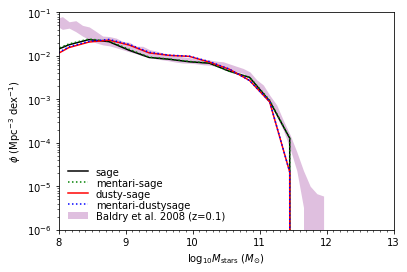

In [35]:
plt.figure()
ax = plt.subplot(111)

binwidth = 0.3
rec_frac=0.43
Hubble_h = 0.73
w = np.where((G_history[0].StellarMass > 0) & (G_history[0].MetalsStellarMass > 0))[0]
mass = np.log10(G_history[0].StellarMass[w] * 1.e10 / Hubble_h)

w1 = np.where((G_history_dusty[0].StellarMass > 0.0)& (G_history_dusty[0].MetalsStellarMass > 0))[0]
mass1 = np.log10(G_history_dusty[0].StellarMass[w1] * 1.e10 / Hubble_h)

w2 = np.where((metals_dusty[:,63] > 0) & (mass_dusty[:,63] / Hubble_h > 0))[0]
mass2 = np.log10(mass_dusty[:,63][w2] / Hubble_h)

w3 = np.where((metals_sage[:,63] > 0) & (mass_sage[:,63] / Hubble_h > 0))[0]
mass3 = np.log10(mass_sage[:,63][w3] / Hubble_h)

#c_mass = np.log10(MassHist_old[0]*MetalHist_old[0] * (1. - rec_frac) / Hubble_h) #final computed mass #final computed mass

mi = np.floor(min(mass)) - 2
ma = np.floor(max(mass)) + 2
ma = 14
NB = int((ma - mi) / binwidth)

(counts, binedges) = np.histogram(mass, range=(mi, ma), bins=NB)
(counts1, binedges1) = np.histogram(mass1, range=(mi, ma), bins=NB)
(counts2, binedges2) = np.histogram(mass2, range=(mi, ma), bins=NB)
(counts3, binedges3) = np.histogram(mass3, range=(mi, ma), bins=NB)

# Set the x-axis values to be the centre of the bins
xaxeshisto = binedges[:-1] + 0.5 * binwidth
xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth
xaxeshisto2 = binedges2[:-1] + 0.5 * binwidth
xaxeshisto3 = binedges2[:-1] + 0.5 * binwidth

plt.plot(xaxeshisto, counts / (BoxSize/Hubble_h)**3 / binwidth, 'k-', label='sage')
plt.plot(xaxeshisto3, counts3 / (BoxSize/Hubble_h)**3 / binwidth, 'g:', label='mentari-sage')
plt.plot(xaxeshisto1, counts1/ (BoxSize/Hubble_h)**3 / binwidth, 'r-', label='dusty-sage')
plt.plot(xaxeshisto2, counts2/ (BoxSize/Hubble_h)**3 / binwidth, 'b:', label='mentari-dustysage')

# Baldry+ 2008 modified data used for the MCMC fitting
Baldry = np.array([
            [7.05, 1.3531e-01, 6.0741e-02],
            [7.15, 1.3474e-01, 6.0109e-02],
            [7.25, 2.0971e-01, 7.7965e-02],
            [7.35, 1.7161e-01, 3.1841e-02],
            [7.45, 2.1648e-01, 5.7832e-02],
            [7.55, 2.1645e-01, 3.9988e-02],
            [7.65, 2.0837e-01, 4.8713e-02],
            [7.75, 2.0402e-01, 7.0061e-02],
            [7.85, 1.5536e-01, 3.9182e-02],
            [7.95, 1.5232e-01, 2.6824e-02],
            [8.05, 1.5067e-01, 4.8824e-02],
            [8.15, 1.3032e-01, 2.1892e-02],
            [8.25, 1.2545e-01, 3.5526e-02],
            [8.35, 9.8472e-02, 2.7181e-02],
            [8.45, 8.7194e-02, 2.8345e-02],
            [8.55, 7.0758e-02, 2.0808e-02],
            [8.65, 5.8190e-02, 1.3359e-02],
            [8.75, 5.6057e-02, 1.3512e-02],
            [8.85, 5.1380e-02, 1.2815e-02],
            [8.95, 4.4206e-02, 9.6866e-03],
            [9.05, 4.1149e-02, 1.0169e-02],
            [9.15, 3.4959e-02, 6.7898e-03],
            [9.25, 3.3111e-02, 8.3704e-03],
            [9.35, 3.0138e-02, 4.7741e-03],
            [9.45, 2.6692e-02, 5.5029e-03],
            [9.55, 2.4656e-02, 4.4359e-03],
            [9.65, 2.2885e-02, 3.7915e-03],
            [9.75, 2.1849e-02, 3.9812e-03],
            [9.85, 2.0383e-02, 3.2930e-03],
            [9.95, 1.9929e-02, 2.9370e-03],
            [10.05, 1.8865e-02, 2.4624e-03],
            [10.15, 1.8136e-02, 2.5208e-03],
            [10.25, 1.7657e-02, 2.4217e-03],
            [10.35, 1.6616e-02, 2.2784e-03],
            [10.45, 1.6114e-02, 2.1783e-03],
            [10.55, 1.4366e-02, 1.8819e-03],
            [10.65, 1.2588e-02, 1.8249e-03],
            [10.75, 1.1372e-02, 1.4436e-03],
            [10.85, 9.1213e-03, 1.5816e-03],
            [10.95, 6.1125e-03, 9.6735e-04],
            [11.05, 4.3923e-03, 9.6254e-04],
            [11.15, 2.5463e-03, 5.0038e-04],
            [11.25, 1.4298e-03, 4.2816e-04],
            [11.35, 6.4867e-04, 1.6439e-04],
            [11.45, 2.8294e-04, 9.9799e-05],
            [11.55, 1.0617e-04, 4.9085e-05],
            [11.65, 3.2702e-05, 2.4546e-05],
            [11.75, 1.2571e-05, 1.2571e-05],
            [11.85, 8.4589e-06, 8.4589e-06],
            [11.95, 7.4764e-06, 7.4764e-06],
            ], dtype=np.float32)

Baldry_xval = np.log10(10 ** Baldry[:, 0]  /Hubble_h/Hubble_h)
Baldry_xval = Baldry_xval - 0.26  # convert back to Chabrier IMF
Baldry_yvalU = (Baldry[:, 1]+Baldry[:, 2]) * Hubble_h*Hubble_h*Hubble_h
Baldry_yvalL = (Baldry[:, 1]-Baldry[:, 2]) * Hubble_h*Hubble_h*Hubble_h

plt.fill_between(Baldry_xval, Baldry_yvalU, Baldry_yvalL, facecolor='purple', alpha=0.25, label='Baldry et al. 2008 (z=0.1)')

plt.yscale('log', nonposy='clip')
plt.axis([8.0, 13.0, 1.0e-6, 1.0e-1])

# Set the x-axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))

plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1})$')  # Set the y...
plt.xlabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$')  # and the x-axis labels

leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')

#plt.savefig('SMF_z0.png')
plt.show()

In [ ]:
#given_metals = np.log10(G_history[0].MetalsStellarMass/G_history[0].StellarMass)
given_metals = np.log10(G_history_dusty[0].MetalsStellarMass * 1e10/ Hubble_h)
given_mass = np.log10(G_history_dusty[0].StellarMass * 1e10/ Hubble_h)

w = np.where(Mass[:,63] > 0)[0]
computed_metals_new = np.log10(Metals[:,63][w]/ Hubble_h)
computed_mass_new = np.log10(Mass[:,63][w]/ Hubble_h)
'''
w = np.where(MassHist_old[26] > 0)[0]
computed_metals_old = np.log10(MetalHist_old[26][w])
computed_mass_old = np.log10(MassHist_old[26][w])
'''
w = np.where(given_mass > 8)
plt.plot(given_mass[w], given_metals[w], '.', label='dusty sage')

w = np.where(computed_mass_new > 8)
plt.plot(computed_mass_new[w], computed_metals_new[w], '.', label='new model')

#plt.plot(computed_mass_old, computed_metals_old, '.', label='old model')

plt.legend(loc=0)
plt.xlabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$')  # and the x-axis labels
plt.ylabel('Stellar Metallicity')
#plt.savefig('old_metals_z1.png')

In [ ]:
w = np.where(mass_dusty[:,63] == max(mass_dusty[:,63]))[0]
mass_dusty_new = list(mass_dusty[w] / Hubble_h)
metals_dusty_new = list(metals_dusty[w])

In [ ]:
w = np.where(mass_sage[:,63] == max(mass_sage[:,63]))[0]
mass_sage_new = list(mass_sage[w] / Hubble_h)
metals_sage_new = list(metals_sage[w])

In [ ]:
age = np.asarray([0.0124, 0.0246, 0.0491, 0.1037, 0.1871, 0.2120, 0.2399, 0.2709, 0.3054, 0.3438, 0.3864, 0.4335, 0.4856, 0.5430, 0.6062, 0.6756, 0.7517, 0.8349, 0.9259, 1.0249, 1.1327, 1.2496, 1.3763, 1.5131, 1.6606, 1.8192, 1.9895, 2.1717, 2.3662, 2.5734, 2.7934, 3.0265, 3.2726, 3.5318, 3.8038, 4.0886, 4.3856, 4.6944, 5.0144, 5.3488, 5.6849, 6.0337, 6.3901, 6.7531, 7.1215, 7.4940, 7.8694, 8.2464, 8.6238, 9.0004, 9.3750, 9.7463, 10.1133, 10.4750, 10.8303, 11.1783, 11.5181, 11.8490, 12.1702, 12.4811, 12.7810, 13.0695, 13.3459, 13.6098])
lookbacktime = sorted((np.array([13.6098]*len(age)) - age) * 1.e9)

In [ ]:
wavelength_dusty, spectra_dusty = mtr.generate_SED(0,age, mass_dusty_new, metals_dusty_new)

In [ ]:
wavelength_sage, spectra_sage = generate_SED(0,age, mass_sage_new, metals_sage_new)

In [ ]:
print(max(mass_dusty[:,63]),max(mass_sage[:,63]))

In [ ]:
wavelength_dusty_all, spectra_dusty_all = generate_SED(0,age, mass_dusty, metals_dusty)

In [ ]:
wavelength_sage_all, spectra_sage_all = generate_SED(0,age, mass_sage, metals_sage)

In [ ]:
filter_list = ('TwoMass_Ks', 'Sdss_u', 'Sdss_g', 'Sdss_r', 'Sdss_i', 'Sdss_z')
z = 0.

In [ ]:
plt.plot(age, np.log10(mass_new[0]), label = "mentari")
#plt.plot(age, np.log10(mass_old), label= "old model")
plt.legend(loc=0)
plt.xlabel(r'$\mathrm{Age}\ \mathrm{Myr}$')
plt.ylabel(r'$\log \mathrm{M_*} \mathrm{(M_\odot)}$')
#plt.savefig('masshist.png')

In [ ]:
plt.plot(age, np.log10(metals_new[0]/mass_new[0]), label = "mentari")
#plt.plot(age, np.log10(metals_old), label= "old model")
plt.legend(loc=0)
plt.xlabel(r'$\mathrm{Age}\ \mathrm{Myr}$')
plt.ylabel(r'$\mathrm{Stellar}\ \mathrm{metallicity}$')
#plt.savefig('metalhist.png')

In [ ]:
import mentari as mtr

In [ ]:
BoxSize = 62.5
Hubble_h = 0.73

firstfile = 0
lastfile = 7
directory = 'mini-millennium/' #change this to the output directory of sage
filename = 'model'
redshift = [127.000, 79.998, 50.000, 30.000, 19.916, 18.244, 16.725, 15.343, 14.086, 12.941, 11.897, 10.944, 10.073, 9.278, 8.550, 7.883, 7.272, 6.712, 6.197, 5.724, 5.289, 4.888, 4.520, 4.179, 3.866, 3.576, 3.308, 3.060, 2.831, 2.619, 2.422, 2.239, 2.070, 1.913, 1.766, 1.630, 1.504, 1.386, 1.276, 1.173, 1.078, 0.989, 0.905, 0.828, 0.755, 0.687, 0.624, 0.564, 0.509, 0.457, 0.408, 0.362, 0.320, 0.280, 0.242, 0.208, 0.175, 0.144, 0.116, 0.089, 0.064, 0.041, 0.020, 0.000]
#redshift = [127.000, 79.998, 50.000, 30.000, 19.916, 18.244, 16.725, 15.343, 14.086, 12.941, 11.897, 10.944, 10.073, 9.278, 8.550, 7.883, 7.272, 6.712, 6.197, 5.724, 5.289, 4.888, 4.520, 4.179, 3.866, 3.576, 3.308, 3.060, 2.831, 2.619, 2.422, 2.239, 2.070, 1.913, 1.766, 1.630, 1.504, 1.386]

In [ ]:
MassHist_old, MetalHist_old = mtr.build_history(redshift, firstfile, lastfile, directory, filename)

In [ ]:
rec_frac = 0.43
c_mass = MassHist_old[0] * (1. - rec_frac) / Hubble_h #final computed mass
w = np.where(c_mass == max(c_mass))[0]

In [ ]:
wavelength_old, spectra_old = mtr.generate_SED(lookbacktime, MassHist_old[:,w], MetalHist_old[:,w]) #wavelength in Angstorm, spectra in Lsun/Angstorm

In [ ]:
#To plot the spectra:

ax = plt.subplot2grid((1,1), (0,0))
#divider = make_axes_locatable(ax)
ax.plot(np.array(wavelength_dusty), spectra_dusty[0] * np.array(wavelength_dusty), lw=0.5, label='dusty_sage')
ax.plot(np.array(wavelength_sage), spectra_sage[0] * np.array(wavelength_sage), lw=0.5, label='sage')
#ax.plot(np.array(wavelength_old), spectra_old[0] * np.array(wavelength_old), lw=0.5, label='sage')

plt.legend()

ax.set_xlabel(r'$\lambda\ (\AA) $')
ax.set_ylabel(r'log $\lambda L_{\lambda} (L_{\odot})$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.savefig('SED-massive.png')

In [ ]:
mab_old = mtr.mab(wavelength_old, spectra_old, filter_list, z)

In [ ]:
mab_new = mtr.mab(wavelength_new, spectra_new, filter_list, z)

In [ ]:
Metallicity = Metals / Mass

In [ ]:
wavelength_all_new, spectra_all_new = generate_SED_v2(0, age, Mass, Metallicity) #wavelength in Angstorm, spectra in Lsun/Angstorm

In [ ]:
%lprun -f generate_SED_v2 generate_SED_v2(0, age, Mass, Metallicity)

In [ ]:
w = np.where(Mass[:,63] > 0)[0]
spectra_all_new_v2 = spectra_all_new[w] / Hubble_h

In [ ]:
mab_list_dusty = compute_mab(wavelength_dusty_all, spectra_dusty_all, filter_list, z)

In [ ]:
mab_list_sage = compute_mab(wavelength_sage_all, spectra_sage_all, filter_list, z)

In [ ]:
mab_list_old = mtr.mab(wavelength_all_old, spectra_all_old / Hubble_h, filter_list, z)

In [ ]:
#plot the Luminosity Function vs Kelvin et al. 2013

hubble=0.73
label = ['Mu', 'Mg', 'Mr', 'Mi', 'Mz']
color = ('grey', 'black', 'blue', 'red', 'green', 'purple')

mi = -30.0
ma = -15.0
binwidth = 0.3
NB = int((ma - mi) / binwidth)
M = np.arange(mi, ma, 0.01)

plt.figure()
ax =plt.subplot(111)

# Observations from Kelvin et al. 2013
'''
# SDSS u
Mstar = -18.53
alpha1 = -0.91
phistar1 = 0.00964
alpha2 = 1.25
phistar2 = 0.00146
xval = 10.0 ** (0.4*(Mstar-M))
yval = 0.4 * np.log(10.0) * (phistar1 * xval ** (alpha1+1) + phistar2 * xval ** (alpha2+1)) * np.exp(-xval)      
plt.plot(M, yval, '--', c=color[1], lw=0.5, label='Kelvin et al (2013)')

# SDSS g
Mstar = -20.28
alpha1 = -1.29
phistar1 = 0.00351
alpha2 = 0.06
phistar2 = 0.00488
xval = 10.0 ** (0.4*(Mstar-M))
yval = 0.4 * np.log(10.0) * (phistar1 * xval ** (alpha1+1) + phistar2 * xval ** (alpha2+1)) * np.exp(-xval)          
plt.plot(M, yval, '--', c=color[2],lw=0.5)

# SDSS r
Mstar = -20.90
alpha1 = -1.13
phistar1 = 0.00451
alpha2 = 0.53
phistar2 = 0.00301
xval = 10.0 ** (0.4*(Mstar-M))
yval = 0.4 * np.log(10.0) * (phistar1 * xval ** (alpha1+1) + phistar2 * xval ** (alpha2+1)) * np.exp(-xval)          
plt.plot(M, yval, '--', c=color[3],lw=0.5)

# SDSS i
Mstar = -21.45
alpha1 = -1.35
phistar1 = 0.00220
alpha2 = -0.09
phistar2 = 0.00487
xval = 10.0 ** (0.4*(Mstar-M))
yval = 0.4 * np.log(10.0) * (phistar1 * xval ** (alpha1+1) + phistar2 * xval ** (alpha2+1)) * np.exp(-xval)              
plt.plot(M, yval, '--', c=color[4], lw=0.5, label='Kelvin et al (2013)')

# SDSS z
Mstar = -21.78
alpha1 = -1.46
phistar1 = 0.0014
alpha2 = -0.26
phistar2 = 0.00505
xval = 10.0 ** (0.4*(Mstar-M))
yval = 0.4 * np.log(10.0) * (phistar1 * xval ** (alpha1+1) + phistar2 * xval ** (alpha2+1)) * np.exp(-xval)                
plt.plot(M, yval, '--', c=color[5], lw=0.5)
'''
twomass_k = [0]
ug = [1, 2]
sdss_r = [3]
sdss_i = [4]
sdss_z = [5]
iz=[4, 5]
sdss =[1,2,3,4,5]

for i in twomass_k:
    
    counts, binedges = np.histogram(mab_list_dusty[i], range=(mi, ma), bins=NB)
    xaxeshisto = binedges[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto, counts/ ((BoxSize/Hubble_h)**3) / binwidth, c=color[i], lw=1.0)
    
    counts, binedges = np.histogram(mab_list_sage[i], range=(mi, ma), bins=NB)
    xaxeshisto = binedges[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto, counts/ ((BoxSize/Hubble_h)**3) / binwidth, c=color[i], lw=0.5)
    
counts, binedges = np.histogram(mab_list_dusty[i], range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ ((BoxSize/Hubble_h)**3) / binwidth, c=color[i], lw=1.0, label='dusty-sage')

counts, binedges = np.histogram(mab_list_sage[i], range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ ((BoxSize/Hubble_h)**3) / binwidth, c=color[i], lw=0.5, label='sage')

plt.yscale('log', nonposy='clip')
plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1})$')  # Set the y...
plt.xlabel(r'$M$')
plt.ylim(2e-4, 1e-1)
plt.xlim(-24, -16.5)
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
plt.savefig('k.png')
plt.show()

In [ ]:
wavelength_all_old, spectra_all_old = mtr.generate_SED(lookbacktime, MassHist_old, MetalHist_old) #wavelength in Angstorm, spectra in Lsun/Angstorm

In [ ]:
print(z)

In [9]:
entries = [e for e in os.listdir(directory) 
           if os.path.isfile(os.path.join(directory, e))]
entries = [e for e in entries if e.startswith('model_z')]
redshift_strings = list(set([re.match(r'model_z(\d+\.?\d*)_\d+', e).group(1)
                            for e in entries]))
group_strings = list(set([re.match(r'model_z\d+\.?\d*_(\d+)', e).group(1)
                        for e in entries]))

group_strings.sort(key=lambda x: int(x))
redshift_strings.sort(key=lambda x: float(x), reverse=True)
'''
if SAM_option == 0:
    Galdesc_false = galdtype(align=False)
    Galdesc=galdtype(align=True)
elif SAM_option == 1:
    Galdesc_false = galdtype_dusty(align=False)
    Galdesc=galdtype_dusty(align=True)
else:
    print("Choose a SAM: 0 - for SAGE, 1 - for Dusty-SAGE")

#open files
for group in group_strings:
    files = []
    for redshift in redshift_strings:
        fn = 'model_z%s_%s' % (redshift, group)
        files.append(open(os.path.join(directory, fn), 'rb'))
'''

['0', '1', '2', '3', '4', '5', '6', '7']


'\nif SAM_option == 0:\n    Galdesc_false = galdtype(align=False)\n    Galdesc=galdtype(align=True)\nelif SAM_option == 1:\n    Galdesc_false = galdtype_dusty(align=False)\n    Galdesc=galdtype_dusty(align=True)\nelse:\n    print("Choose a SAM: 0 - for SAGE, 1 - for Dusty-SAGE")\n\n#open files\nfor group in group_strings:\n    files = []\n    for redshift in redshift_strings:\n        fn = \'model_z%s_%s\' % (redshift, group)\n        files.append(open(os.path.join(directory, fn), \'rb\'))\n'

In [12]:
firstfile = 2
lastfile = 5

for group in group_strings:
    if (int(group) > firstfile-1) & (int(group) < lastfile+1):
        print(group)

2
3
4
5


In [13]:
for group in range(firstfile, lastfile+1):
    print(group)

2
3
4
5
